In [1]:
%pip install pandas

import pandas as pd

file_path = "BBM409_S25_PA1_Dataset_v1/part_i.csv"
df = pd.read_csv(file_path)

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install numpy scikit-learn matplotlib seaborn
# !pip install numpy scikit-learn matplotlib seaborn

import numpy as np

# To visualize
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# **Part I: Textual Data Analysis ✍🏻**

In [3]:
# Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=['number']).columns  # Select numeric columns
categorical_cols = df.select_dtypes(exclude=['number']).columns  # Select categorical columns (CLASS)

# Number of numerical and categorical columns
num_numerical_features = len(numeric_cols)
num_categorical_features = len(categorical_cols)

print(f"Total numerical features: {num_numerical_features}")
print(f"Total categorical features: {num_categorical_features}")

Total numerical features: 106
Total categorical features: 1



Missing values in categorical columns:
 Series([], dtype: int64)


/var/folders/tv/v5jdxc154fx7qdyd5fsmb4pr0000gn/T/ipykernel_35764/467487882.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_missing_numerical.index, y=top_missing_numerical.values, hue=None, legend=False, palette="viridis")


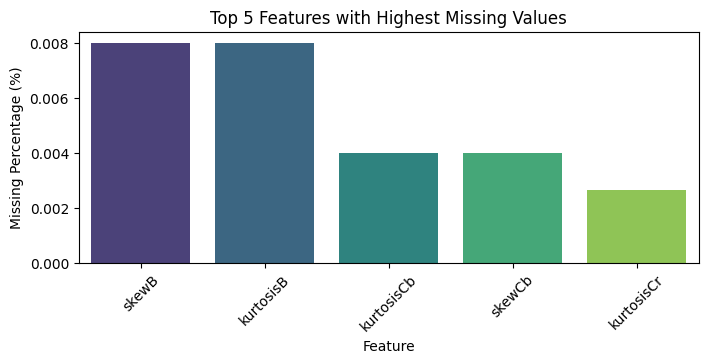

In [4]:
# Check for missing values in categorical columns
missing_categorical = df[categorical_cols].isnull().sum()
print("\nMissing values in categorical columns:\n", missing_categorical[missing_categorical > 0])

# Calculate missing percentage for numerical columns
missing_numerical_percentages = (df[numeric_cols].isnull().sum() / len(df)) * 100

# List the top 5 numerical features with the highest missing percentage
top_missing_numerical = missing_numerical_percentages.sort_values(ascending=False).head(5)

# 📊 Plot the top 5 missing features (Fixed Warning)
plt.figure(figsize=(8, 3))
sns.barplot(x=top_missing_numerical.index, y=top_missing_numerical.values, hue=None, legend=False, palette="viridis")
plt.xlabel("Feature")
plt.ylabel("Missing Percentage (%)")
plt.title("Top 5 Features with Highest Missing Values")
plt.xticks(rotation=45)
plt.show()

### **Handling Missing Values For Numerical Columns 🤔❓ (Mean Imputation)**  

In this assignment, we have decided to fill the missing values using the **mean imputation method** (i.e. completing the missing values with mean values). The dataset contains **106 numerical features and 75,000 samples**. Instead of checking the normality of each feature and deciding what to do with the each attribute's missing values, we have followed a more **pragmatic approach**. Individiually doing that for every attribute would be **time-consuming and inefficient**.

**In previous chart, we checked the missing value percentages** for each feature. If most of the features had extremely high percentages of missing values, We have considered handling it differently. As we can see the most percentage is less than 1%.

To conclude, since this project is **not** related to human life or a medical application, and the proportion of missing values **are lower than 1%**, using mean imputation is an efficient approach for handling missing data in this context.

In [5]:
# Apply mean imputation on numerical columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Merge the whole dataset
df_final = pd.concat([df[numeric_cols], df[categorical_cols]], axis=1)

# Verify missing values after imputation
missing_values_after = df_final.isnull().sum().sum()  # Total missing values
print(f"\nTotal missing values after mean imputation: {missing_values_after}")


Total missing values after mean imputation: 0


### **Visualizing the Difference Between Max and Min Values 📊**

When plotting the feature ranges (difference between min and max values), we noticed that **features with extremely large ranges dominate the visualization**, causing **small-range features to become nearly invisible**.

To **resolve this issue**, we applied **log transformation (`np.log1p`)** to the feature ranges. So this transformation, **prevents** the bigger differences to shadow the smaller ones and **provides** a better comparison.


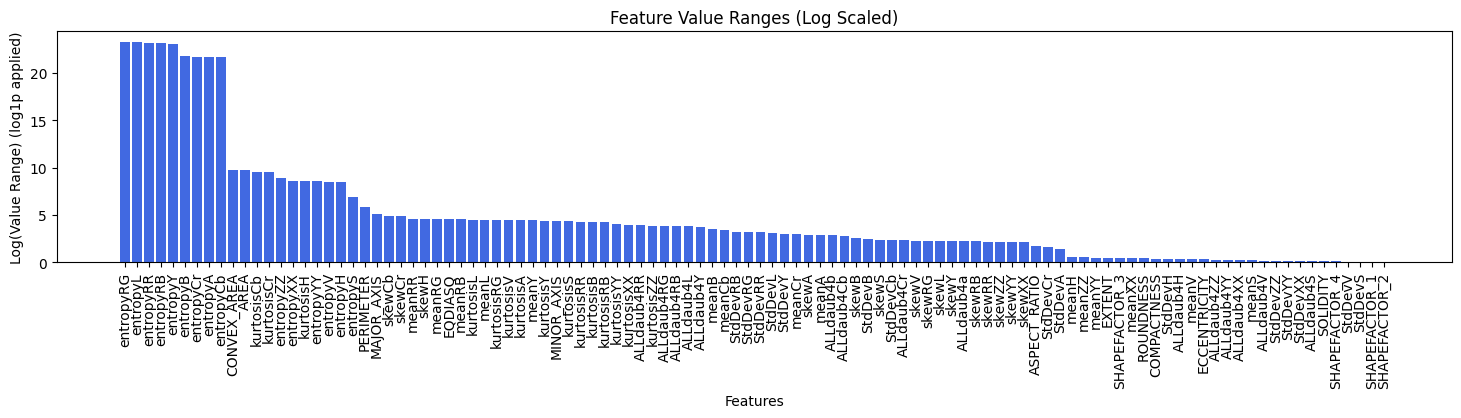

In [6]:
# Checking feature ranges
feature_ranges = df_final.iloc[:, :-1].agg(["min", "max"]).T
feature_ranges["range"] = feature_ranges["max"] - feature_ranges["min"]

# Sorting by range
feature_ranges = feature_ranges.sort_values(by="range", ascending=False)

# Apply log transformation to prevent small values from disappearing (values closer to 0 cannot be seen)
feature_ranges["log_range"] = np.log1p(feature_ranges["range"])

# Plot
plt.figure(figsize=(18, 3))
plt.bar(feature_ranges.index, feature_ranges["log_range"], color="royalblue")
plt.ylabel("Log(Value Range) (log1p applied)")
plt.xlabel("Features")
plt.title("Feature Value Ranges (Log Scaled)")
plt.xticks(rotation=90)
plt.show()

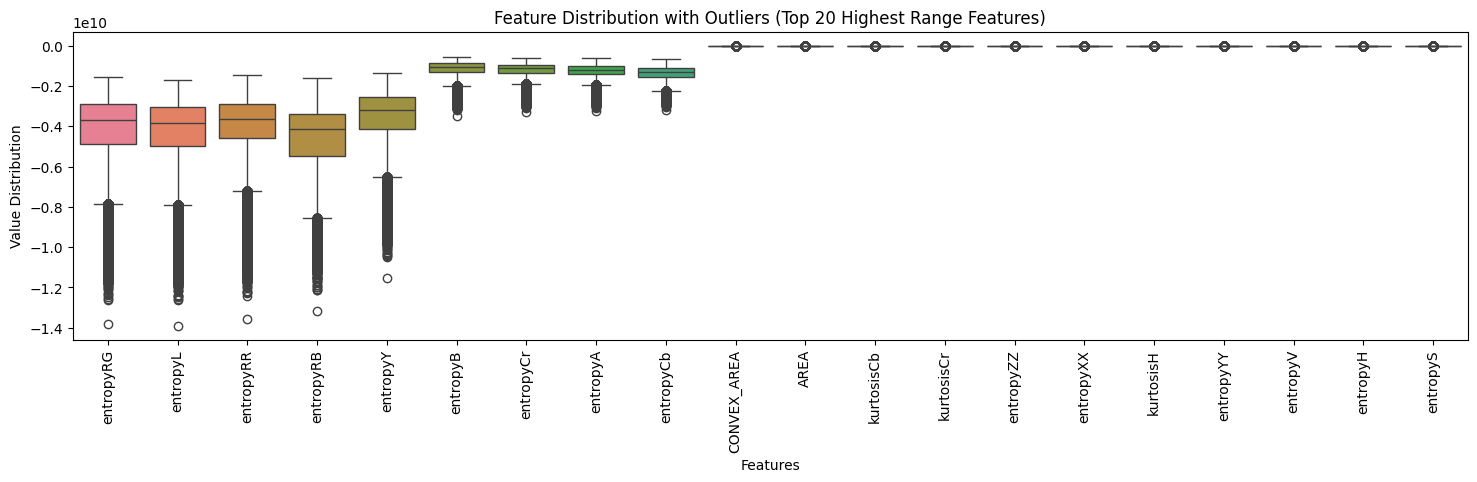

In [7]:
# Selecting a subset of features for visualization (Top 20 highest range features to avoid overcrowding)
selected_features = feature_ranges.index[:20]  # Taking the top 20 features with the highest range

# Creating a boxplot to visualize outliers
plt.figure(figsize=(18, 4))
sns.boxplot(data=df_final[selected_features])
plt.xticks(rotation=90)
plt.title("Feature Distribution with Outliers (Top 20 Highest Range Features)")
plt.xlabel("Features")
plt.ylabel("Value Distribution")
plt.show()

## **Handling Feature Scale Variation 🤔📊**  

As observed in the above **boxplot**, our dataset contains **highly different scales** and **many outliers**, such as in the features like `entropyRG`, `entropyL`, and `entropyRR`.

### **Why we have chosen RobustScaler to scale our data?**  
✔ **Handles outliers effectively** by using **median and IQR**, unlike StandardScaler, which is affected by extreme values. Since we have many outliers particular attributes, we have decided to use RobustScaler.

✔ **Prevents large-magnitude features from dominating** while maintaining meaningful distributions.

✔ **Provides more stability than MinMaxScaler**, which is sensitive to extreme minimum and maximum values.

**In Conclusion,** because of the multiple outliers, we have chosen **RobustScaler** to ensure stable feature scaling without being overly affected by extreme values.

### **Example Scaling for the entropyRG Feature**
We have selected **entropyRG** as an example feature and applied RobustScaler without altering the original data distribution.  
  This feature was chosen because it contains outliers, making it a great candidate to demonstrate how RobustScaler effectively handles extreme values.
This ensures that we only scale the feature values while preserving the overall shape and structure of the data.

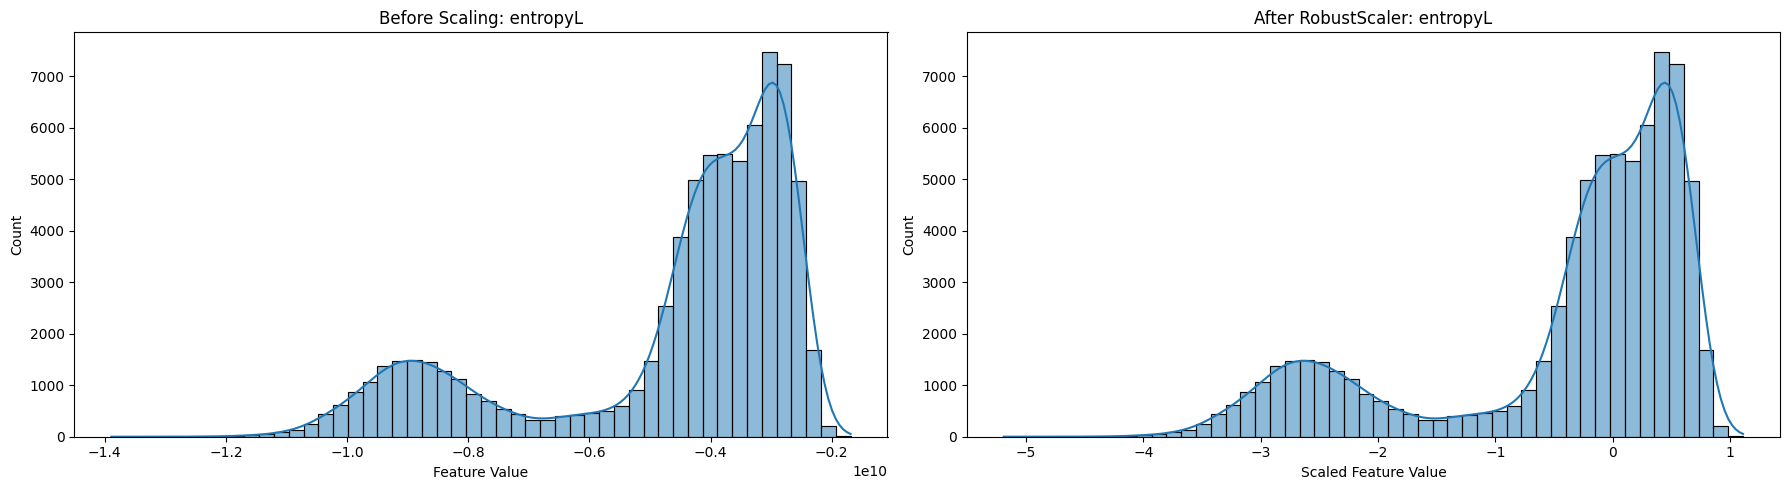

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

# Select original data (excluding CLASS column)
X_original = df_final.iloc[:, :-1]  # Exclude the target column (CLASS)

# Apply RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_original)  # Scale all numerical features

# Select entropyL as the feature to visualize scaling effects
feature_name = "entropyL"
feature_index = df_final.columns.get_loc(feature_name)

# 📊 BEFORE & AFTER SCALING VISUALIZATION
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# BEFORE SCALING (Original Data)
sns.histplot(X_original.iloc[:, feature_index], bins=50, kde=True, ax=ax[0])
ax[0].set_title(f"Before Scaling: {feature_name}")
ax[0].set_xlabel("Feature Value")
ax[0].set_ylabel("Count")

# AFTER SCALING (Using RobustScaler)
sns.histplot(X_scaled[:, feature_index], bins=50, kde=True, ax=ax[1])
ax[1].set_title(f"After RobustScaler: {feature_name}")
ax[1].set_xlabel("Scaled Feature Value")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [9]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## **Splitting Train and Test 🚂** (with shuffle)

In [10]:
# Split dataset into train and test sets (Shuffle is enabled)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, df_final.iloc[:, -1], test_size=0.2, stratify=df_final.iloc[:, -1], shuffle=True, random_state=42
)

In [11]:
# Define models (each will be trained separately)
weighted_knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="linear"),
    "Weighted KNN": weighted_knn
}

# Train and Evaluate Each Model Separately to see the each time taken
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for model_name, model in models.items():
    start_time = time.time()  # Measure start time

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="accuracy")

    # Train model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Measure end time
    end_time = time.time()
    training_time = end_time - start_time

    # Store results
    results[model_name] = {
        "Training Time": training_time,
        "CV Accuracy Mean": np.mean(cv_scores),
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="macro"),
        "Recall": recall_score(y_test, y_pred, average="macro"),
        "F1 Score": f1_score(y_test, y_pred, average="macro"),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

# Convert Results to DataFrame for Visualization
results_df = pd.DataFrame(results).T

## **Model Training Time Comparison ⏳**

/var/folders/tv/v5jdxc154fx7qdyd5fsmb4pr0000gn/T/ipykernel_35764/2311424380.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["Training Time"], palette="coolwarm")


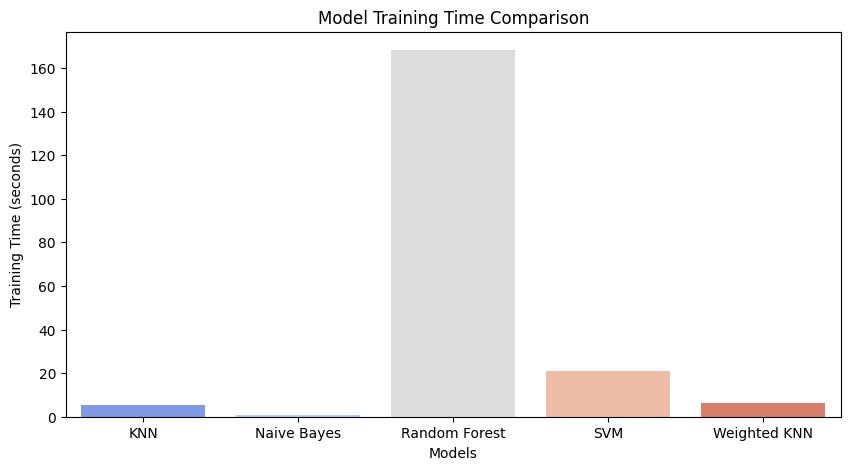

In [12]:
# Plot Training Time Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df["Training Time"], palette="coolwarm")
plt.title("Model Training Time Comparison")
plt.ylabel("Training Time (seconds)")
plt.xlabel("Models")
plt.show()

## **Model Accuracy Comparison 🎯**

/var/folders/tv/v5jdxc154fx7qdyd5fsmb4pr0000gn/T/ipykernel_35764/2073402169.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["Test Accuracy"], palette="viridis")


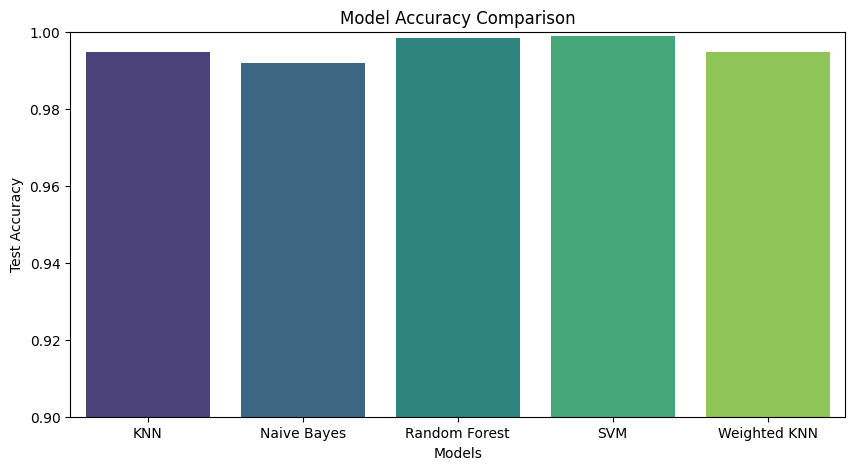

In [13]:
# Plot Accuracy Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df["Test Accuracy"], palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Test Accuracy")
plt.xlabel("Models")
plt.ylim(0.9, 1)  # Zoom into accuracy range
plt.show()

## **Model Performance Metrics 📊**

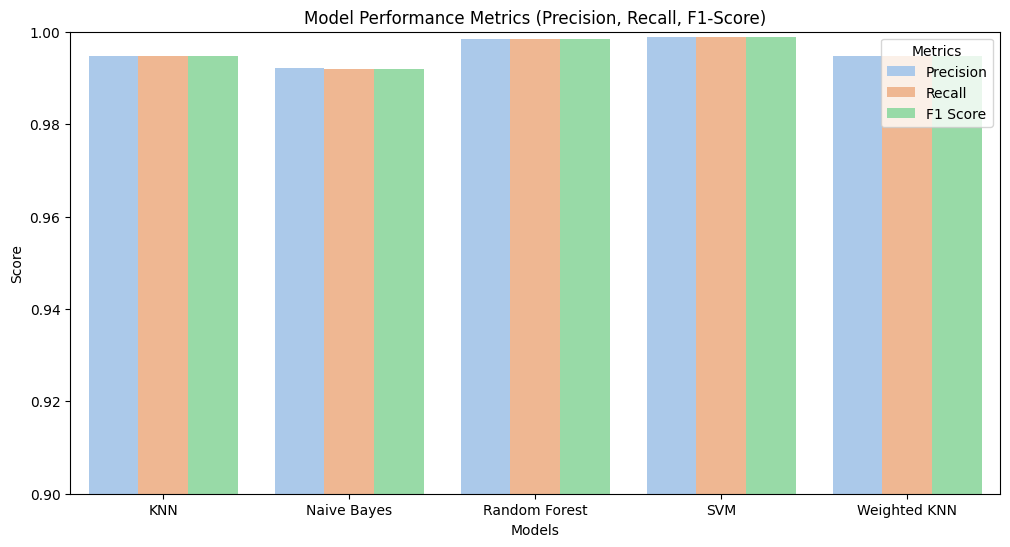

KNN              0.994667
Naive Bayes         0.992
Random Forest    0.998333
SVM              0.998933
Weighted KNN     0.994733
Name: Test Accuracy, dtype: object
KNN               0.99468
Naive Bayes      0.992084
Random Forest    0.998335
SVM              0.998934
Weighted KNN     0.994746
Name: Precision, dtype: object
KNN              0.994667
Naive Bayes         0.992
Random Forest    0.998333
SVM              0.998933
Weighted KNN     0.994733
Name: Recall, dtype: object
KNN              0.994671
Naive Bayes      0.992007
Random Forest    0.998334
SVM              0.998933
Weighted KNN     0.994738
Name: F1 Score, dtype: object


In [14]:
# Plot Precision, Recall, and F1 Score Comparison
metrics = ["Precision", "Recall", "F1 Score"]
metrics_df = results_df[metrics].melt(ignore_index=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x="index", y="value", hue="variable", data=metrics_df, palette="pastel")
plt.title("Model Performance Metrics (Precision, Recall, F1-Score)")
plt.ylabel("Score")
plt.xlabel("Models")
plt.ylim(0.9, 1)
plt.legend(title="Metrics")
plt.show()

print(results_df["Test Accuracy"])
print(results_df["Precision"])
print(results_df["Recall"])
print(results_df["F1 Score"])

## **Confusion Matrices for Models 🤯**

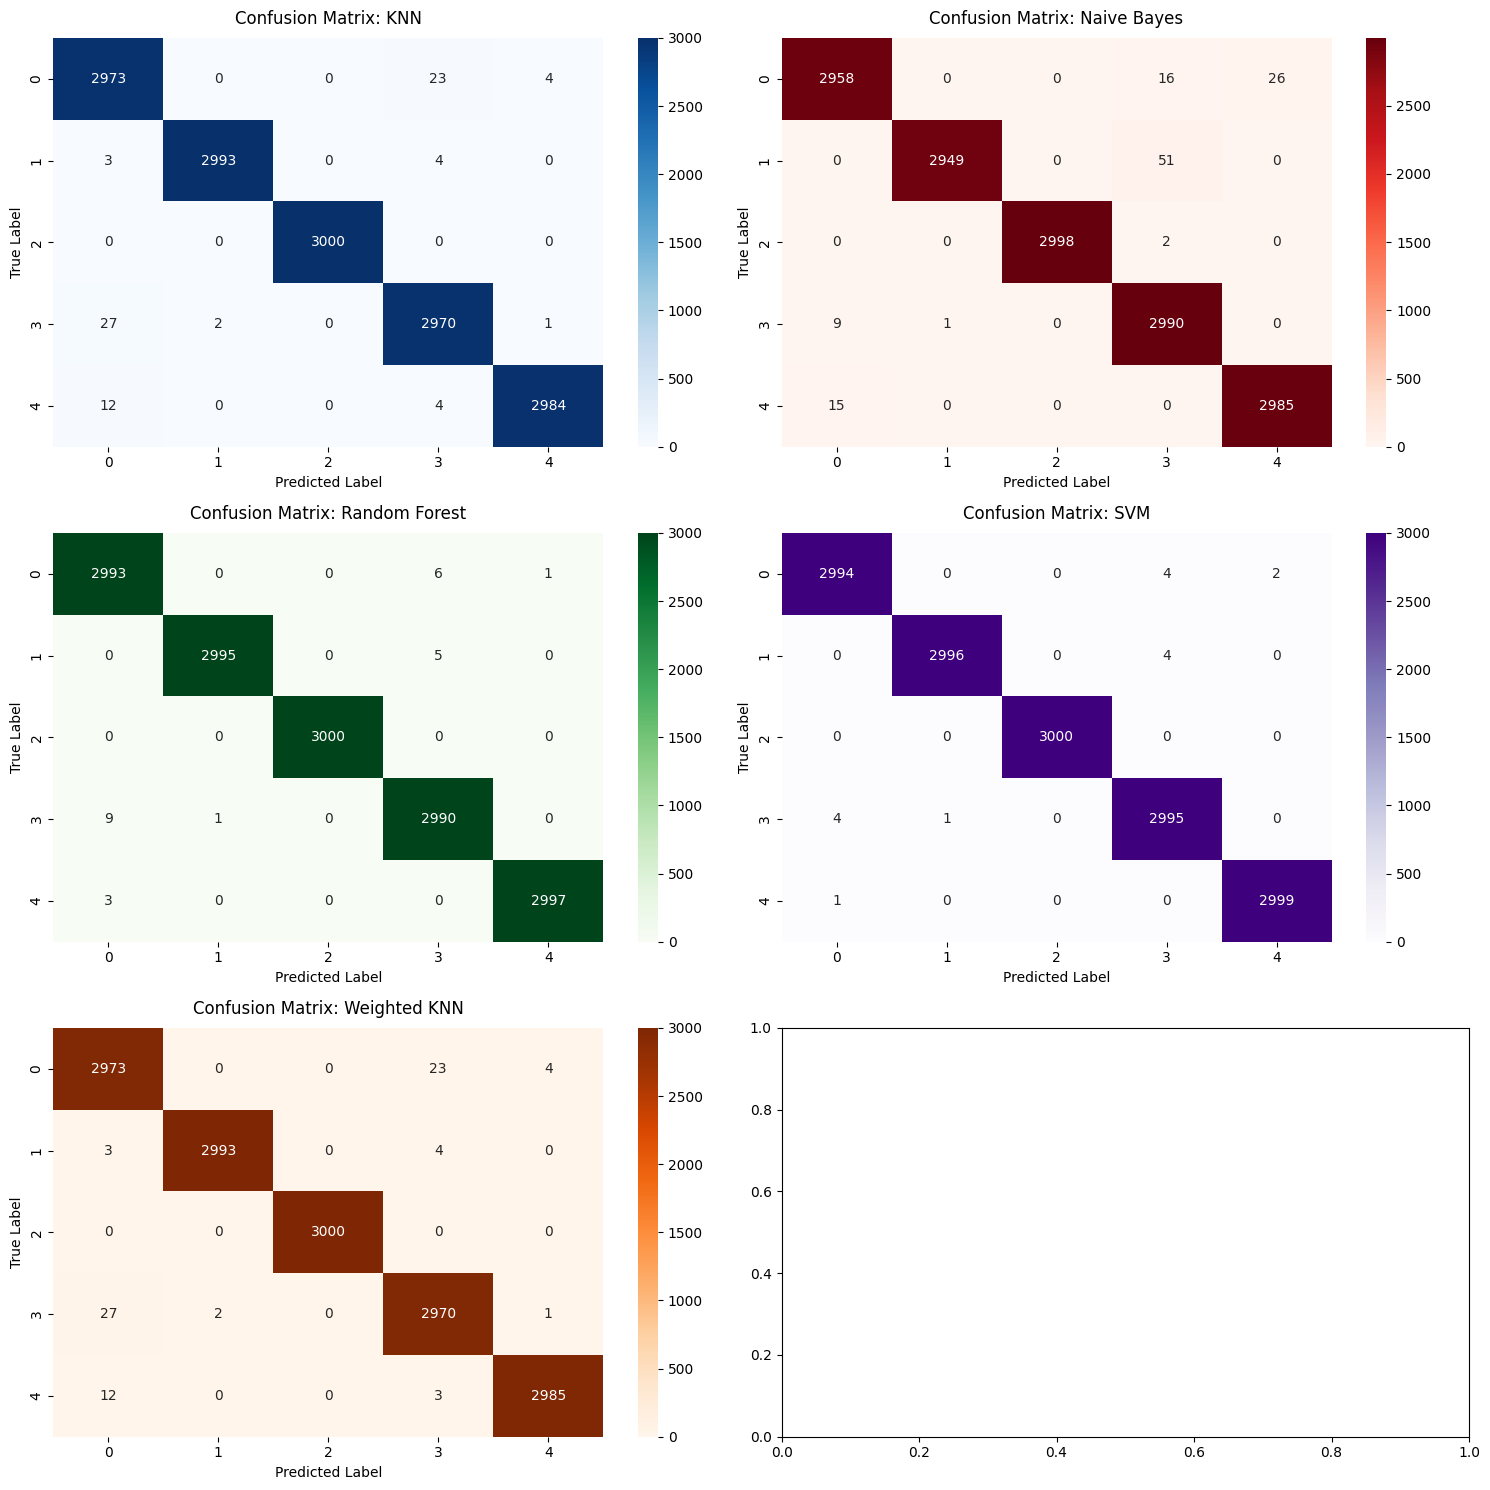

In [15]:
# Define color palettes for different models
color_maps = ['Blues', 'Reds', 'Greens', 'Purples', 'Oranges', 'YlOrBr']

# Plot Confusion Matrices for Each Model
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.ravel()

for i, (model_name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap=color_maps[i], ax=axes[i])
    axes[i].set_title(f"Confusion Matrix: {model_name}", pad=10)
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")

plt.tight_layout()
plt.show()

# **Part II: Image Data Analysis 📸**

In [1]:
%pip install numpy opencv-python tqdm

import os
import numpy as np
import cv2
from tqdm import tqdm
import time

# Base directory and labels
data_dir = "BBM409_S25_PA1_Dataset_v1/part_ii"
labels = {"Arborio": 0, "Basmati": 1, "Ipsala": 2, "Jasmine": 3, "Karacadag": 4}

# Check if preprocessed data exists
cache_file = "processed_data.npz"

if os.path.exists(cache_file):
    # Load from cache
    print("⚡️ Loading preprocessed data...")
    data = np.load(cache_file)
    X, y = data['X'], data['y']
else:
    # Process and save the data
    print("⏳ Processing images and saving to cache...")
    features, targets = [], []

    start_time = time.time()

    for rice_type in tqdm(labels):
        rice_dir = os.path.join(data_dir, rice_type)
        for img_file in os.scandir(rice_dir):
            if img_file.name.endswith(".jpg"):
                try:
                    img = cv2.imread(img_file.path)
                    if img is None:
                        print(f"⚠️ Skipping invalid image: {img_file.path}")
                        continue  # Skip if image is invalid

                    img = cv2.resize(img, (32, 32)).astype(np.float32)

                    # RGB Means
                    r_mean = np.mean(img[:, :, 0])
                    g_mean = np.mean(img[:, :, 1])
                    b_mean = np.mean(img[:, :, 2])

                    # Grayscale Features
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    gray_mean = np.mean(gray)
                    gray_std = np.std(gray)
                    gray_var = np.var(gray)

                    # White Pixel Ratio
                    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
                    white_ratio = np.sum(binary == 255) / (32 * 32)

                    # Combine features
                    features.append([r_mean, g_mean, b_mean, gray_mean, gray_std, gray_var, white_ratio])
                    targets.append(labels[rice_type])

                except Exception as e:
                    print(f"Error processing image {img_file.path}: {e}")

    # Convert to NumPy arrays and save to cache
    X = np.array(features, dtype=np.float32)
    y = np.array(targets)

    np.savez_compressed(cache_file, X=X, y=y)
    end_time = time.time()
    print(f"✅ Processing and saving completed in {end_time - start_time:.2f} seconds")

print(f"✅ Final dataset shape: {X.shape}")

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
⚡️ Loading preprocessed data...
✅ Final dataset shape: (75000, 7)


### **Image Preprocessing Strategy (RGB + Grayscale) 🎨**

#### **Why Both RGB and Grayscale?**
- **RGB Mean Values** (`r_mean`, `g_mean`, `b_mean`): Color information is crucial for distinguishing between different rice types, as color variations can be significant features.
- **Grayscale Statistical Features** (`gray_mean`, `gray_std`, `gray_var`): Grayscale simplifies the data while retaining essential texture and shape information.
- **White Pixel Ratio**: After binary thresholding, it captures the proportion of white pixels, which can reflect shape and texture differences.

By combining **color and texture information**, we ensure a richer feature set, minimizing data loss.

---

#### **⚡️ How Did We Speed Up the Process?**
1. **Image Resizing**: Reduced all images to `32x32` pixels to minimize processing time.  
2. **Parallel Processing**: Used `ThreadPoolExecutor` with 16 workers to process images concurrently.  
3. **Data Caching**: Saved processed features into a `.npz` file. This allows for instant data loading in future operations, avoiding repetitive computations.  
4. **Efficient Error Handling**: Skipped invalid images to prevent processing bottlenecks.  
5. **Optimized Data Types**: Used `np.float32` for efficient memory and faster computation.

---

##### 🗂️ **Usage of a Cache File (`processed_data.npz`)**  
- The cache file is used **only during the assignment process** to speed up data loading.  
- Instead of processing images repeatedly, we save the processed features once.  
- This allows for **faster and more efficient model training and testing**, reducing redundant computations.

In [2]:
%pip install numpy pandas scikit-learn seaborn matplotlib

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Load preprocessed data
data = np.load("processed_data.npz")
X, y = data['X'], data['y']

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


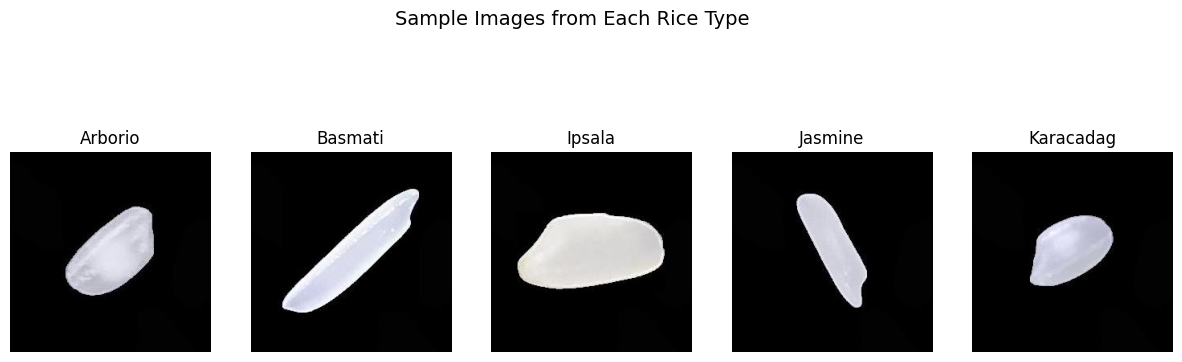

In [3]:
# Install necessary libraries
%pip install numpy pandas scikit-learn seaborn matplotlib opencv-python
# !pip install numpy pandas scikit-learn seaborn matplotlib opencv-python

# Import libraries
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load preprocessed data
data = np.load("processed_data.npz")
X, y = data['X'], data['y']

# 🎯 1. Visualize Sample Images from Each Rice Type
rice_types = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]
data_dir = "BBM409_S25_PA1_Dataset_v1/part_ii"

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for idx, rice_type in enumerate(rice_types):
    rice_dir = os.path.join(data_dir, rice_type)
    img_name = random.choice(os.listdir(rice_dir))  # Select a random image
    img_path = os.path.join(rice_dir, img_name)
    
    try:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper visualization
        axes[idx].imshow(img)
        axes[idx].set_title(rice_type)
        axes[idx].axis("off")
    except Exception as e:
        print(f"Error loading image: {e}")
        axes[idx].set_title(f"{rice_type}\n[Image Error]")
        axes[idx].axis("off")

plt.suptitle("Sample Images from Each Rice Type", fontsize=14)
plt.show()

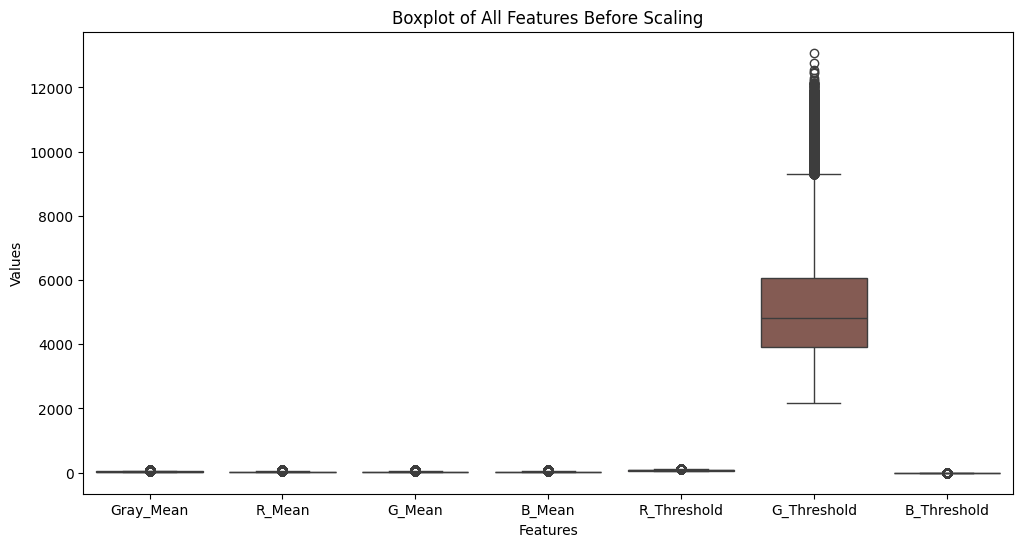

In [4]:
# Boxplot for Outlier Detection (Before Scaling)
df_original = pd.DataFrame(X, columns=["Gray_Mean", "R_Mean", "G_Mean", "B_Mean", "R_Threshold", "G_Threshold", "B_Threshold"])

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_original)
plt.title("Boxplot of All Features Before Scaling")
plt.xlabel("Features")
plt.ylabel("Values")
plt.show()

### ⚖️ **Why We Chose StandardScaler to Scale Our Data?**  

- **StandardScaler** makes features have a **mean of 0** and a **standard deviation of 1** by removing the mean and scaling the data.  

- Models like **SVM** and **KNN** are sensitive to feature scales. Using StandardScaler helps all features contribute equally to the model.  

- In the **above scaling boxplot**, the `G_Threshold` feature had a bigger scale than others, but there were extreme outliers.  

- Since the data is already **numeric and continuous** and outliers are not a big problem, **StandardScaler** was the best choice. It keeps the data consistent and helps improve model accuracy and training.

In [5]:
# Scaling Data using StandardScaler (Chosen after Outlier Analysis)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/Users/mertcetin/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


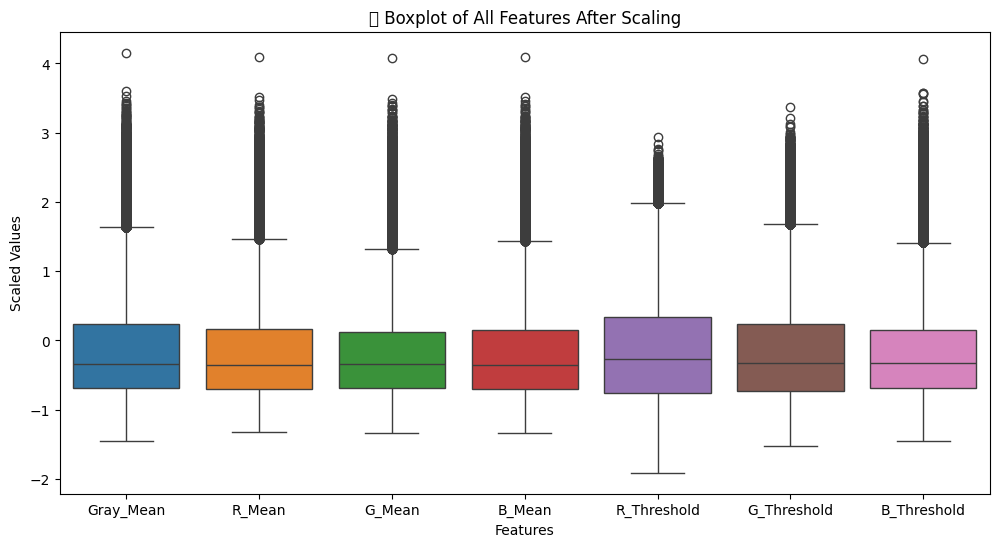

In [6]:
# Boxplot After Scaling to Confirm
df_scaled = pd.DataFrame(X_scaled, columns=["Gray_Mean", "R_Mean", "G_Mean", "B_Mean", "R_Threshold", "G_Threshold", "B_Threshold"])

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_scaled)
plt.title("📊 Boxplot of All Features After Scaling")
plt.xlabel("Features")
plt.ylabel("Scaled Values")
plt.show()

## **Splitting Train and Test 🚂** (with shuffle)

In [7]:
# Split dataset into train and test sets (Shuffle is enabled)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42
)

In [8]:
# Defining models
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Weighted KNN": KNeighborsClassifier(n_neighbors=5, weights='distance'),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="linear", random_state=42)
}

In [ ]:
# Train and Evaluate Each Model
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for model_name, model in models.items():
    start_time = time.time()  # Measure start time
    
    # Cross-validation accuracy
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="accuracy")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Store results
    results[model_name] = {
        "Training Time": time.time() - start_time,
        "CV Accuracy Mean": np.mean(cv_scores),
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="macro"),
        "Recall": recall_score(y_test, y_pred, average="macro"),
        "F1 Score": f1_score(y_test, y_pred, average="macro"),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T

## **Model Training Time Comparison ⏳**

/var/folders/tv/v5jdxc154fx7qdyd5fsmb4pr0000gn/T/ipykernel_35604/1976994504.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["Training Time"], palette="coolwarm")
/Users/mertcetin/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9203 (\N{HOURGLASS WITH FLOWING SAND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


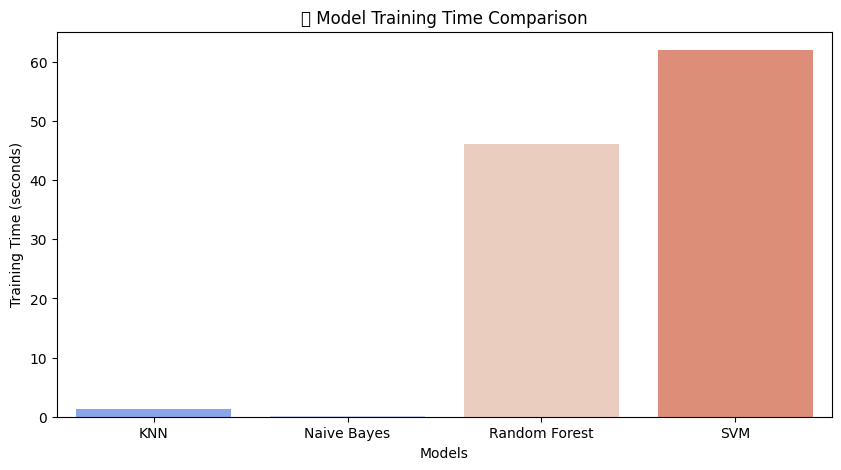

/var/folders/tv/v5jdxc154fx7qdyd5fsmb4pr0000gn/T/ipykernel_35604/1976994504.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["Test Accuracy"], palette="viridis")
/Users/mertcetin/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


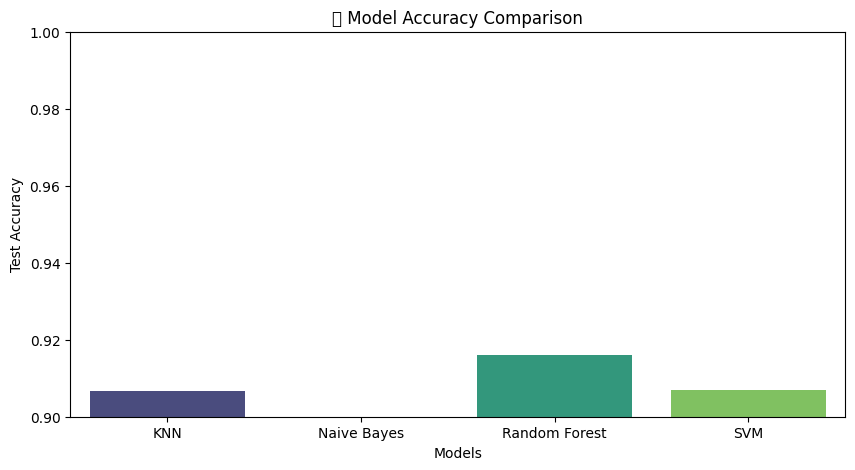

/Users/mertcetin/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


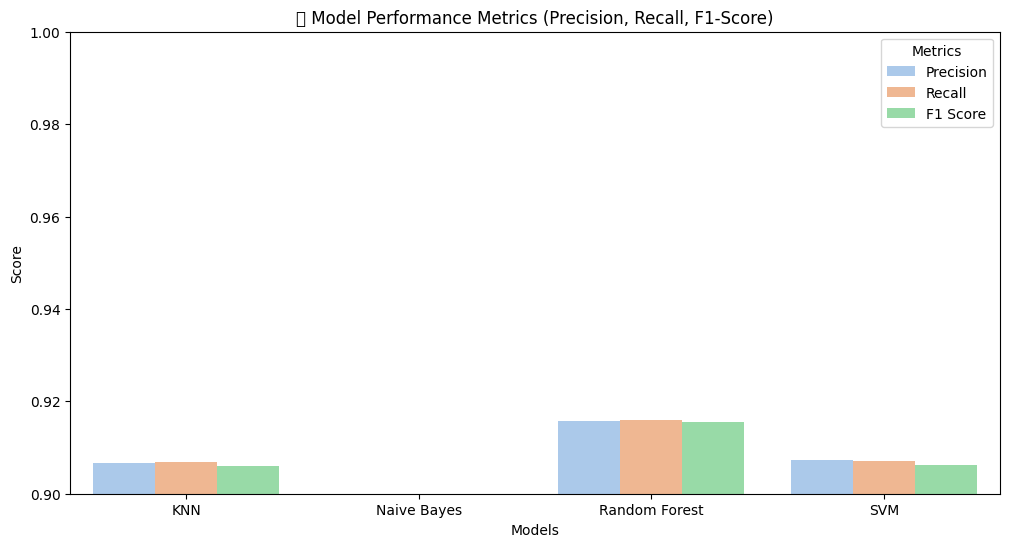

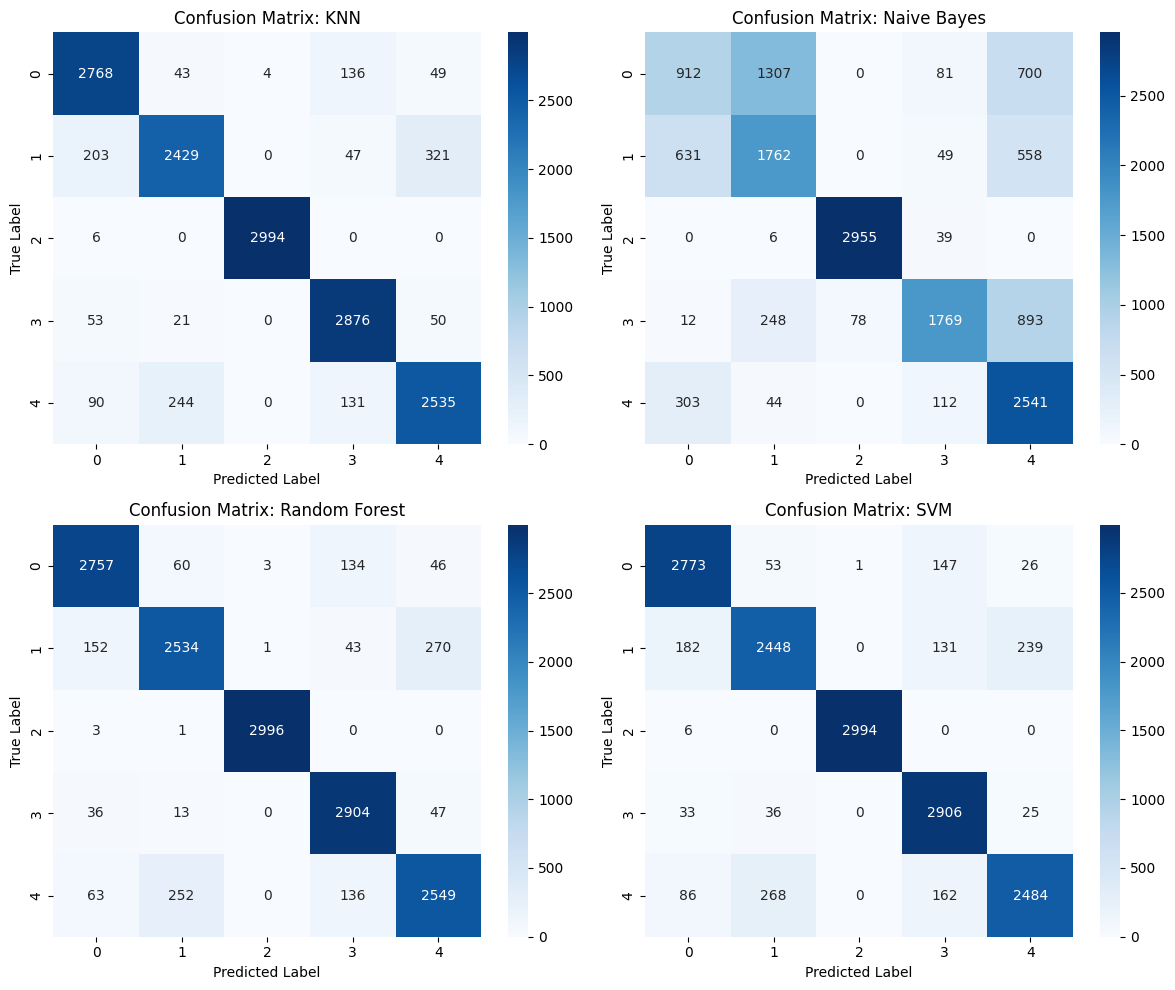

In [ ]:
# Training Time
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df["Training Time"], palette="coolwarm")
plt.title("Model Training Time Comparison")
plt.ylabel("Training Time (seconds)")
plt.xlabel("Models")
plt.show()

## **Model Accuracy Comparison 🎯**

In [ ]:
# Accuracy Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df["Test Accuracy"], palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Test Accuracy")
plt.xlabel("Models")
plt.ylim(0.9, 1)
plt.show()

## **Model Performance Metrics 📊**

In [ ]:
# Precision, Recall, F1 Score
metrics = ["Precision", "Recall", "F1 Score"]
metrics_df = results_df[metrics].melt(ignore_index=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x="index", y="value", hue="variable", data=metrics_df, palette="pastel")
plt.title("Model Performance Metrics (Precision, Recall, F1-Score)")
plt.ylabel("Score")
plt.xlabel("Models")
plt.ylim(0.9, 1)
plt.legend(title="Metrics")
plt.show()

## **Confusion Matrices for Models 🤯**

In [ ]:
# Color maps for each confusion matrix
colormaps = ['coolwarm', 'viridis', 'plasma', 'cividis', 'magma']

# Plot Confusion Matrices with different colors
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, (model_name, model) in enumerate(results.items()):
    sns.heatmap(model["Confusion Matrix"], annot=True, fmt="d", cmap=colormaps[i], ax=axes[i])
    axes[i].set_title(f"Confusion Matrix: {model_name}")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")

plt.tight_layout()
plt.show()